In [1]:
import ast
import shutil
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import face_recognition
from tqdm.auto import tqdm
from PIL import Image

import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import plotly
import plotly.express as px
import plotly.figure_factory as ff

plotly.offline.init_notebook_mode(connected=True)

In [2]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [3]:
def get_clusters(data, algorithm, *args, **kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.max(labels) + 1)
    colors = [palette[x] if x >= 0 else (0,0,0) for x in labels]
    return labels, colors

In [4]:
def scatter_thumbnails(data, images, scale_factor=16, colors=None, show_images=True):
    assert len(data) == len(images)

    # reduce embedding dimentions to 2
    x = PCA(n_components=2).fit_transform(data) if len(data[0]) > 2 else data

    # create a scatter plot.
    f = plt.figure(figsize=(22, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], s=4)
    _ = ax.axis('off')
    _ = ax.axis('tight')

    if show_images:
        # add thumbnails :)
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox
        for i in tqdm(range(len(images))):
            image = plt.imread(images[i])
            h, w = image.shape[:2]
            n_h = int(h/scale_factor)
            n_w = int(w/scale_factor)
            image = cv2.resize(image, (n_w, n_h))
            outputImage = cv2.copyMakeBorder(
                 image, 
                 10, 
                 10, 
                 10, 
                 10, 
                 cv2.BORDER_CONSTANT, 
                 value=colors[i] if colors is not None else None)
            im = OffsetImage(image)
            bboxprops = dict(edgecolor=colors[i]) if colors is not None else None
            ab = AnnotationBbox(im, x[i], xycoords='data',
                                frameon=(bboxprops is not None),
                                pad=0.1,
                                bboxprops=bboxprops)
            ax.add_artist(ab)
    return ax

In [5]:
files = [x for x in Path('./data/images').iterdir()]
files[0]

PosixPath('data/images/S02E04_54096_0.png')

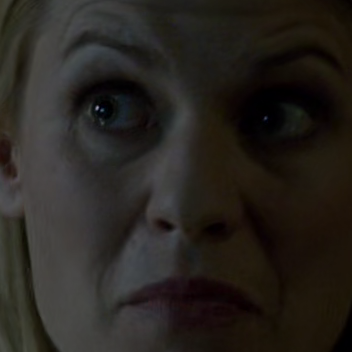

In [6]:
img = Image.open(str(files[0]))
img

In [7]:
frame = cv2.imread(str(files[0]))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
h, w = frame.shape[:2]
print(h, w)

352 352


In [8]:
# encoding = face_recognition.face_encodings(frame_rgb, known_face_locations=[[0, w, h, 0]])
# encoding

In [9]:
df = pd.read_csv('./data/faces.csv', index_col=0)
df.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0..."
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0..."
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0..."
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0...."
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0..."


In [10]:
episode_df = pd.read_csv('./data/episodes.csv', index_col=0)
df = df.merge(episode_df[['imdb_id', 'cast']],
              on='imdb_id',
              how='left'
             )
df.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0...","0000132,0507073,1072555,0362873,1459109,209313..."
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...","0000132,0507073,1072555,0362873,1459109,209313..."
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0...","0000132,0507073,1072555,0362873,1459109,209313..."
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0....","0000132,0507073,1072555,0362873,1459109,209313..."
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0...","0000132,0507073,1072555,0362873,1459109,209313..."


In [11]:
data = []
for file in tqdm(files):
    temp, frame_num, face_num = file.stem.split('_')
    s = int(temp[1:3])
    e = int(temp[4:6])
    datum = {'fp': str(file.absolute().resolve()),
             'season': s,
             'episode': e,
             'frame_num': int(frame_num),
             'face_num': int(face_num)
            }
    data.append(datum)
fp_df = pd.DataFrame(data)
fp_df.head()

  0%|          | 0/249535 [00:00<?, ?it/s]

,fp,season,episode,frame_num,face_num
0,/home/amos/programs/FacesOfHomeland/data/image...,2,4,54096,0
1,/home/amos/programs/FacesOfHomeland/data/image...,7,1,74904,0
2,/home/amos/programs/FacesOfHomeland/data/image...,3,6,60000,0
3,/home/amos/programs/FacesOfHomeland/data/image...,7,2,74520,0
4,/home/amos/programs/FacesOfHomeland/data/image...,8,4,44112,1


In [12]:
df_fp = df.merge(fp_df,
                        on=['frame_num', 'face_num', 'season', 'episode'],
                        how='inner')
df_fp.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast,fp
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0....","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...


In [13]:
episode_fp = df_fp[(df_fp['season'] == 1) &
                   (df_fp['episode'] == 1)]
data = np.array([np.array(ast.literal_eval(x)) for x in episode_fp['encoding'].tolist()])
faces = episode_fp['fp'].tolist()

In [22]:
%%time

# PCA first to speed it up
x = PCA(n_components='mle', svd_solver='full').fit_transform(data)
tsne = TSNE(perplexity=50,
            n_components=2,
            learning_rate=75,
            n_iter=10000,
            early_exaggeration=300,
            # method='exact',
            n_iter_without_progress=300
         )
x = tsne.fit_transform(data)
print(f'Learning rate: {tsne.learning_rate}')
print(f'Number of iterations: {tsne.n_iter}')

Learning rate: 75
Number of iterations: 10000
CPU times: user 12min 27s, sys: 2.12 s, total: 12min 30s
Wall time: 2min 17s


  0%|          | 0/3437 [00:00<?, ?it/s]

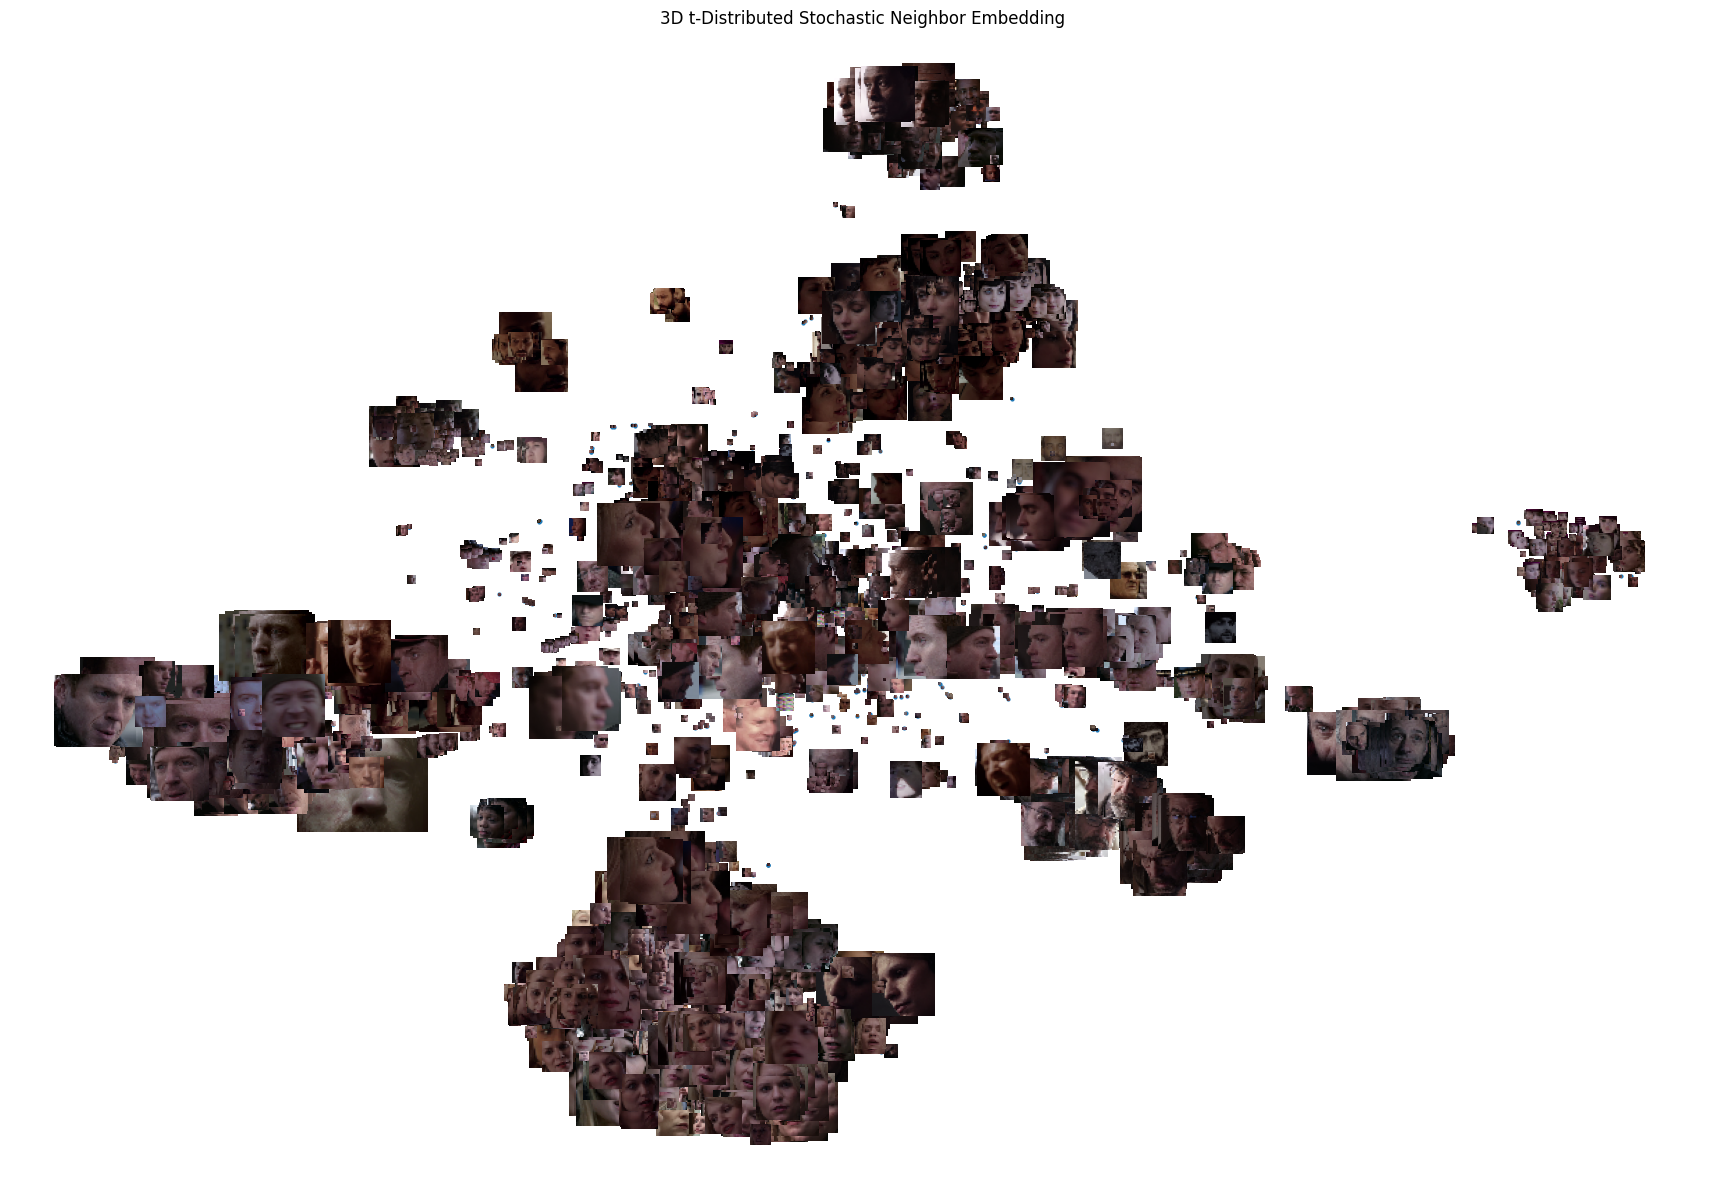

In [23]:
ax = scatter_thumbnails(x, faces, scale_factor=16, show_images=True)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.show()

In [30]:
labels, colors = get_clusters(x, cluster.DBSCAN, n_jobs=-1, eps=5, min_samples=15)
# episode_fp['cluster'] = labels
print(list(set(labels)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1]


  0%|          | 0/3437 [00:00<?, ?it/s]

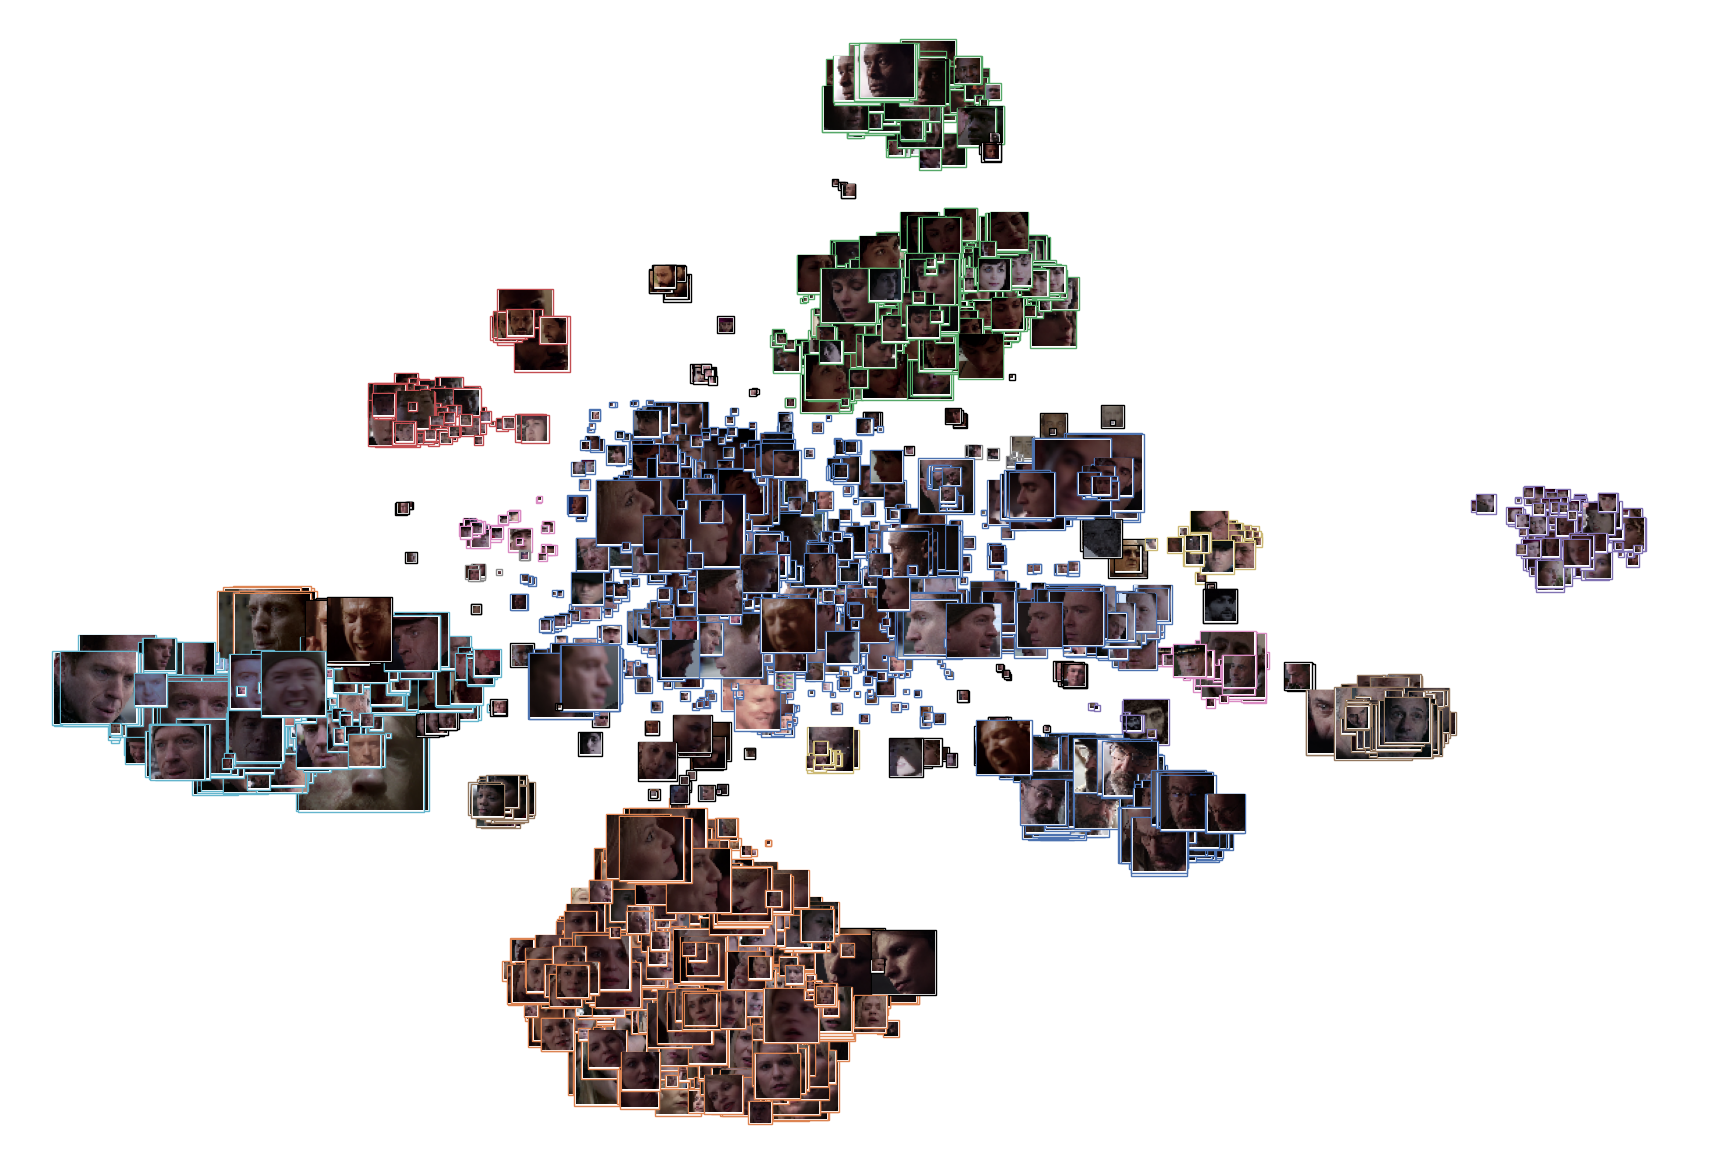

In [31]:
ax = scatter_thumbnails(x, faces, scale_factor=16, colors=colors, show_images=True)

In [71]:
episode_fp['label'] = labels
episode_fp.head()

,imdb_id,frame_num,face_num,x1,y1,x2,y2,img_height,img_width,area,pct_of_frame,season,episode,encoding,cast_x,cast_y,fp,label
0,1811020,192,0,798,196,916,314,1080,1920,13924,0.007,1,1,"[-0.1581144630908966, 0.11875572055578232, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...,0
1,1811020,216,0,1068,389,1491,812,1080,1920,178929,0.086,1,1,"[-0.035924218595027924, 0.09460100531578064, 0...","0000132,0507073,1072555,0362873,1459109,209313...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...,-1
2,1811020,216,1,912,17,1205,311,1080,1920,86142,0.042,1,1,"[-0.10312943160533905, 0.1261938065290451, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...,0
3,1811020,240,0,1090,106,1384,400,1080,1920,86436,0.042,1,1,"[-0.18763160705566406, 0.08110883831977844, 0....","0000132,0507073,1072555,0362873,1459109,209313...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...,0
4,1811020,240,1,674,522,968,816,1080,1920,86436,0.042,1,1,"[-0.11751651763916016, 0.1057925745844841, 0.0...","0000132,0507073,1072555,0362873,1459109,209313...","0000132,0507073,1072555,0362873,1459109,209313...",/home/amos/programs/FacesOfHomeland/data/image...,-1


In [73]:
dst = Path('./data/clustering/S01E01')
if not dst.exists():
    Path.mkdir(dst, parents=True)
for idx, row in tqdm(episode_fp.iterrows(), total=episode_fp.shape[0]):
    fp = dst.joinpath(f'{row["label"]}/{Path(row["fp"]).name}')
    if not fp.parent.exists():
        Path.mkdir(fp.parent)
    shutil.copy(row["fp"], fp)

  0%|          | 0/3437 [00:00<?, ?it/s]

In [127]:
labels, colors = get_clusters(x,
                              cluster.HDBSCAN,
                              n_jobs=-1,
                              store_centers='medoid',
                              min_cluster_size=15, 
                              min_samples=5,
                              cluster_selection_epsilon=5,
                              cluster_selection_method='leaf',
                              leaf_size=1)
print(list(set(labels)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1]


  0%|          | 0/2488 [00:00<?, ?it/s]

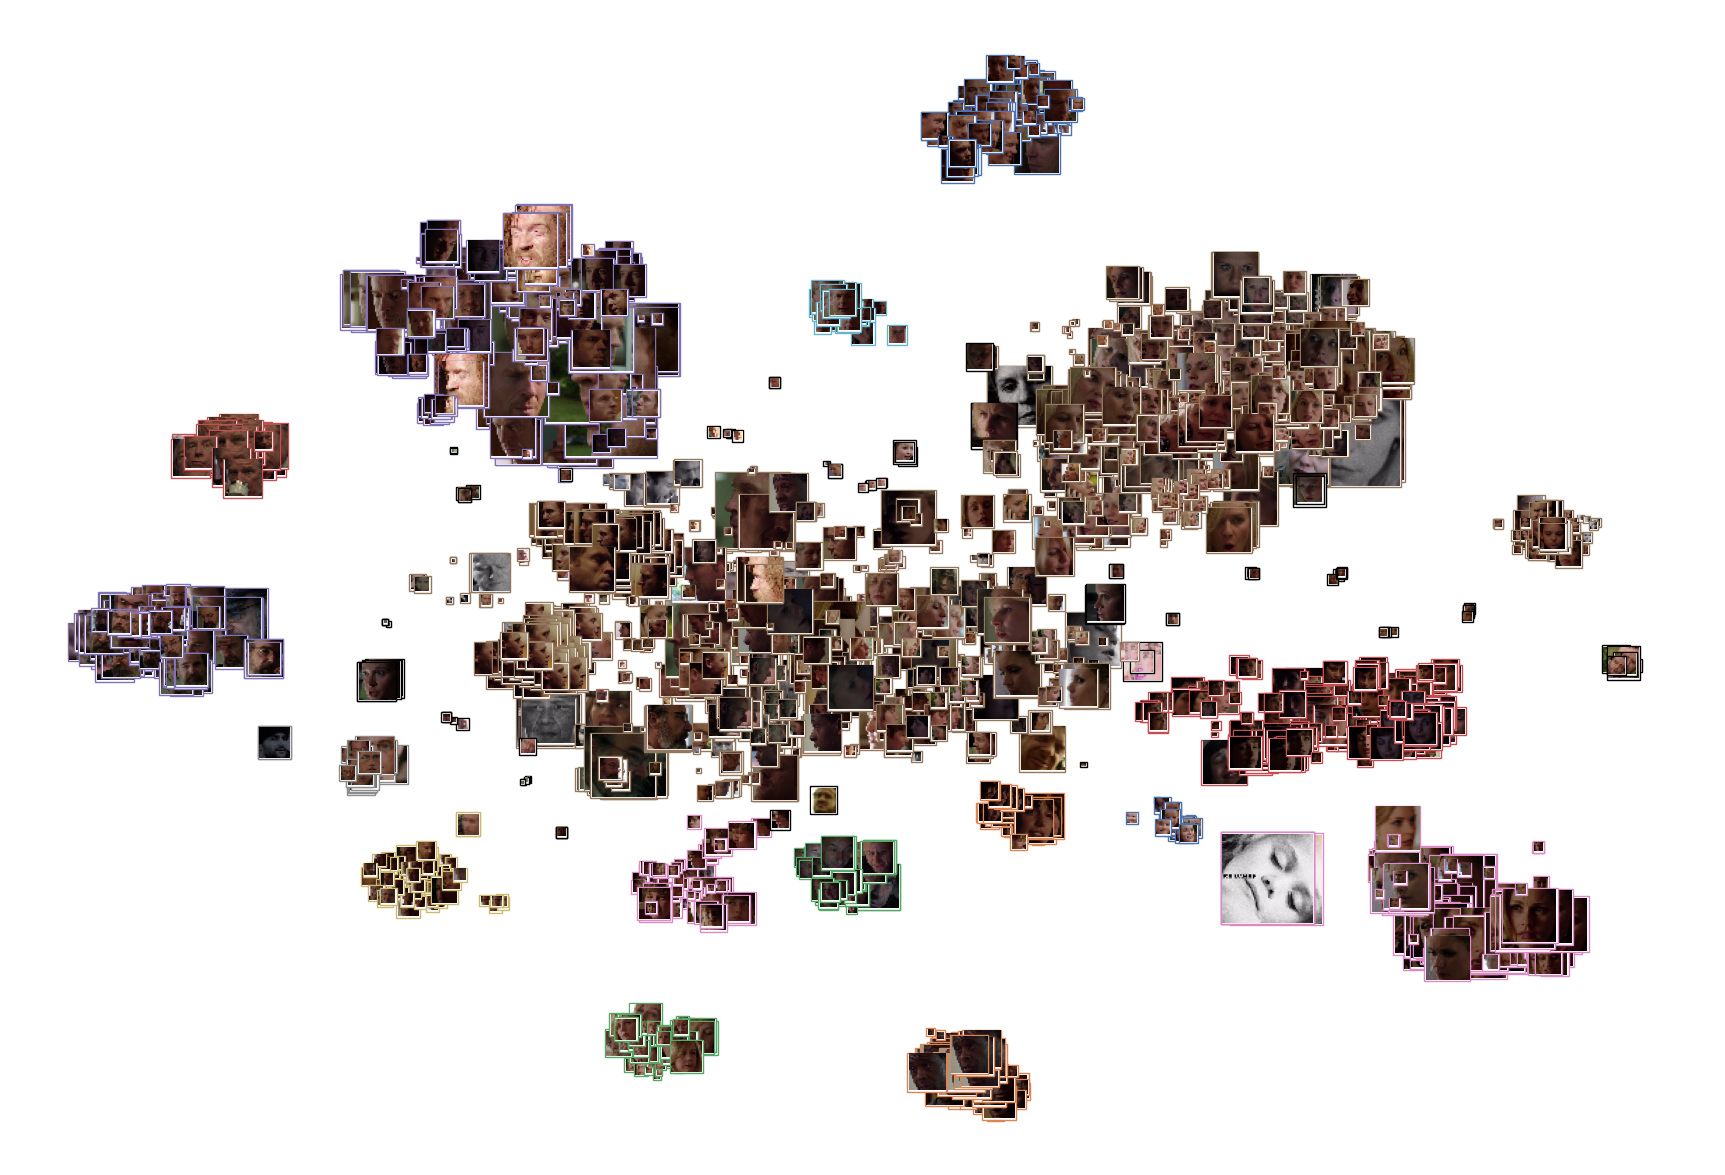

In [128]:
ax = scatter_thumbnails(x, faces, scale_factor=16, colors=colors, show_images=True)

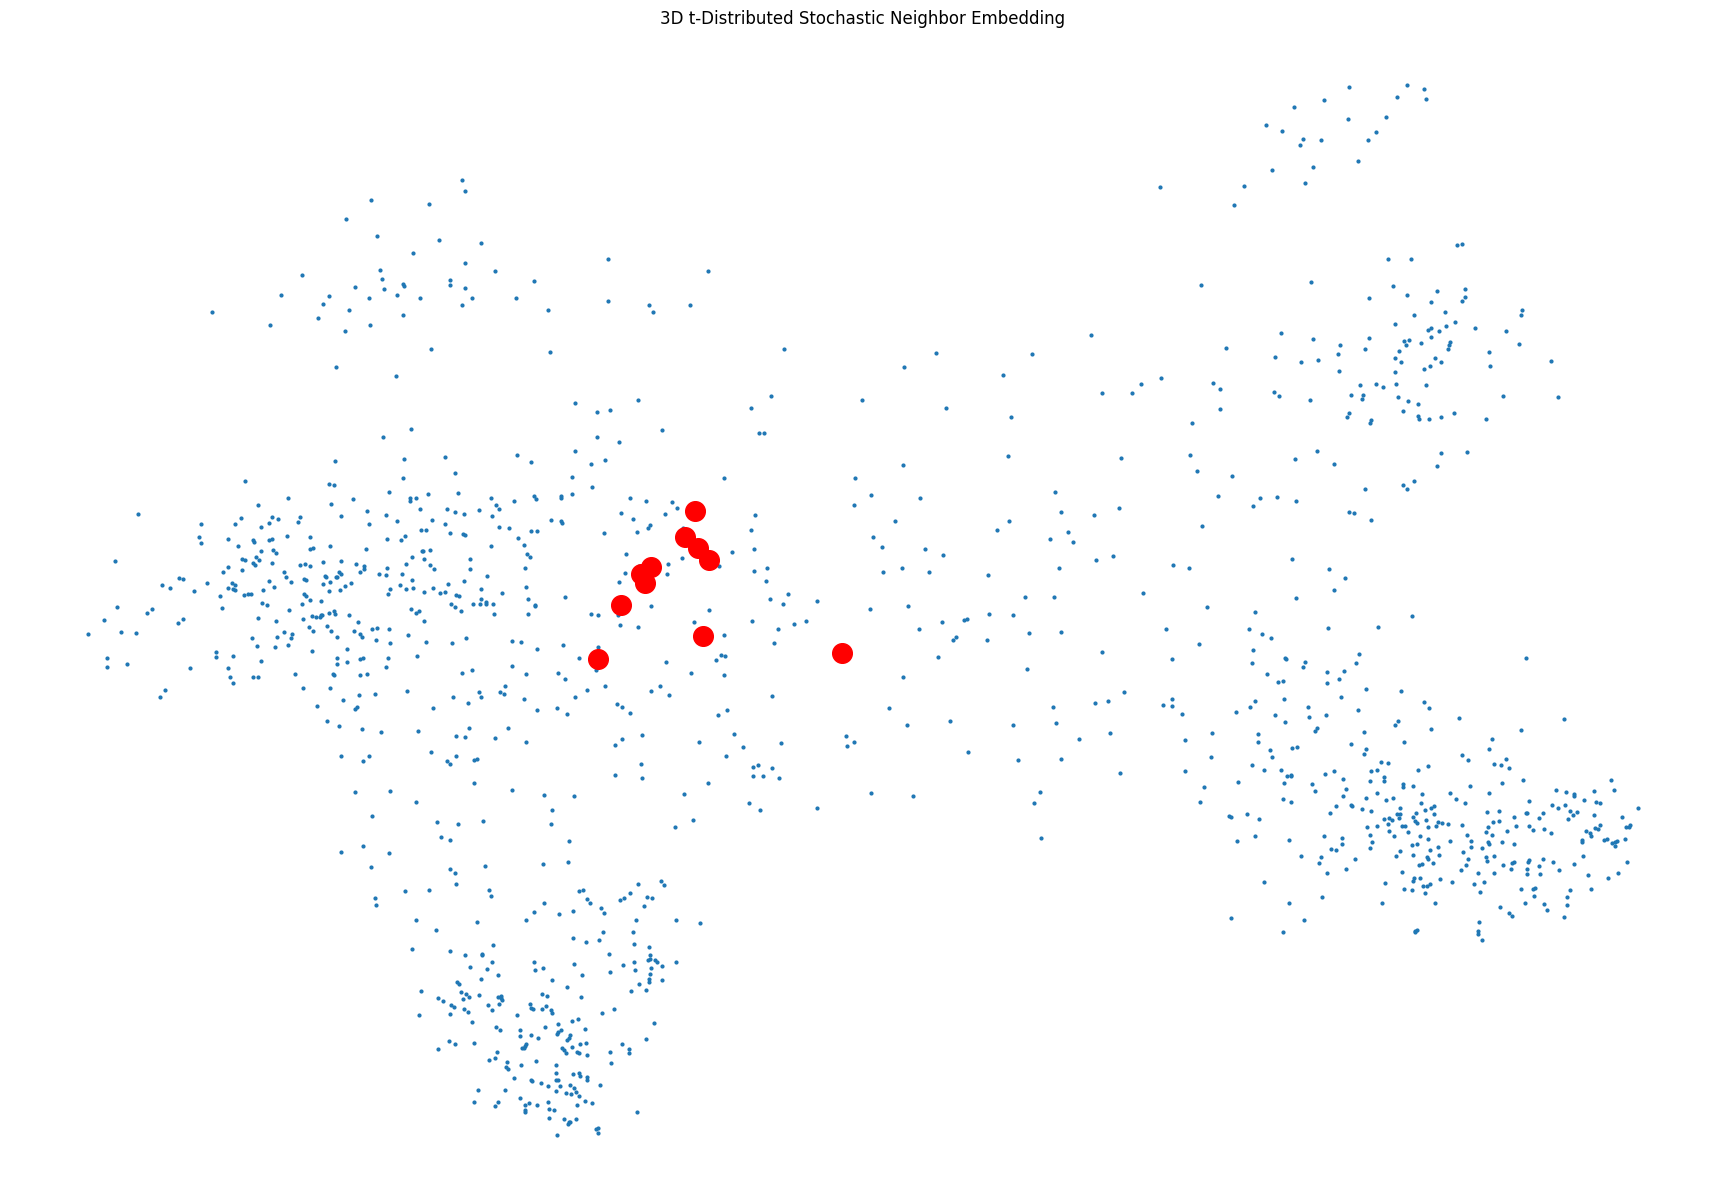

In [33]:
n_clusters = len(list(episode_fp.iloc[0]['cast'].split(',')))

kmeans = cluster.KMeans(n_clusters=11,
                        n_init=20,
                        max_iter=600)
x = kmeans.fit_transform(data)
ax = scatter_thumbnails(x, faces, scale_factor=16, show_images=False)
plt.title('3D t-Distributed Stochastic Neighbor Embedding')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200)
plt.show()